<a href="https://colab.research.google.com/github/StillWork/ds-lab/blob/master/gg_52_cats_and_dogs_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 고양이 강아지 구분
## CNN 이용
- 원래 데이터는 25,000개 (고양이 + 강아지)
- 여기서는 2000개로 학습을 시킨다
- 검증은 1000개의 이미지 사용 

## 데이터 다운로드

In [ ]:
import os, os.path, shutil
# import zipfile
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [1]:
!curl -L \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -o ./cats_and_dogs_filtered.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 65.4M  100 65.4M    0     0  49.3M      0  0:00:01  0:00:01 --:--:-- 49.3M


In [ ]:
!unzip -q cats_and_dogs_filtered.zip

In [ ]:
!apt-get install tree
# command-line tool for handling packages in linux
# !pip install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (148 kB/s)
Selecting previously unselected package tree.
(Reading database ... 144793 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
!tree -d .

.
├── cats_and_dogs_filtered
│   ├── train
│   │   ├── cats
│   │   └── dogs
│   └── validation
│       ├── cats
│       └── dogs
└── sample_data

8 directories


In [ ]:
base_dir = './cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [ ]:
train_cats_dir

'./cats_and_dogs_filtered/train/cats'

## 파일 확인

In [ ]:
os.listdir(train_dogs_dir)[:10]

['dog.481.jpg',
 'dog.907.jpg',
 'dog.812.jpg',
 'dog.598.jpg',
 'dog.637.jpg',
 'dog.804.jpg',
 'dog.576.jpg',
 'dog.455.jpg',
 'dog.806.jpg',
 'dog.839.jpg']

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
print (train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print (train_dog_fnames[:10])

['cat.770.jpg', 'cat.402.jpg', 'cat.365.jpg', 'cat.961.jpg', 'cat.582.jpg', 'cat.831.jpg', 'cat.813.jpg', 'cat.39.jpg', 'cat.549.jpg', 'cat.714.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


In [ ]:
print ('total training cat images:', len(os.listdir(train_cats_dir)))
print ('total training dog images:', len(os.listdir(train_dogs_dir)))
print ('total validation cat images:', len(os.listdir(validation_cats_dir)))
print ('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


## 이미지 샘플 확인

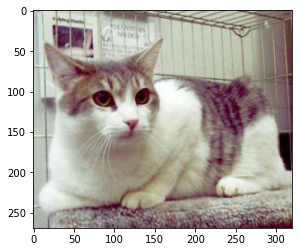

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
img_path = os.path.join(train_cats_dir, train_cat_fnames[0]) 
img = mpimg.imread(img_path)
plt.imshow(img)

In [ ]:
type(img), img.shape, img[0,0,:]

(numpy.ndarray, (269, 320, 3), array([184, 185, 167], dtype=uint8))

## 간단한 CNN을 사용한 모델


In [ ]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 

"""
keras에서는 이미지데이터 학습을 쉽게하도록 하기위해 다양한 패키지를 제공한다. 그 중 
하나가 ImageDataGenerator 클래스이다. ImageDataGenerator 클래스를 통해 객체를 생성할 
때 파라미터를 전달해주는 것을 통해 데이터의 전처리를 쉽게할 수 있고, 또 이 객체의 
flow_from_directory 메소드를 활용하면 폴더 형태로된 데이터 구조를 바로 가져와서 
사용할 수 있다. 이 과정은 매우 직관적이고 코드도 ImageDataGenerator를 사용하지 않는 
방법에 비해 상당히 짧아진다.

출처: https://3months.tistory.com/199 [Deep Play]
"""

#### ImageDataGenerator() object
- Generate batches of tensor image data with real-time data augmentation. The data 
  will be looped over (in batches).
- flow_from_dataframe() method: Takes the dataframe and the path to a directory and 
    generates batches of augmented/normalized data.
- flow_from_directory() method: Takes the path to a directory & generates batches of 
    augmented data.

In [ ]:
img_width = 150
img_height = 150

datagen = ImageDataGenerator(rescale = 1./255)
train_generator = datagen.flow_from_directory(directory=train_dir,
											   target_size=(img_width,img_height),
											   classes=['dogs','cats'],
											   class_mode='binary',
											   batch_size=20)

validation_generator = datagen.flow_from_directory(directory=validation_dir,
											   target_size=(img_width,img_height),
											   classes=['dogs','cats'],
											   class_mode='binary',
											   batch_size=20)

model = models.Sequential()

model.add(layers.Conv2D(32,(3,3), activation = 'relu', 
                        input_shape=(img_width, img_height, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
______________________________________

In [ ]:
# for exercise (just for checking) - it will loop forever, so you need break !
for data_batch, labels_batch in train_generator:
    print(data_batch.shape, labels_batch.shape)
    break

(20, 150, 150, 3) (20,)


- .fit은 전체 학습 데이터 세트가 메모리에 맞고 데이터 증가가 적용되지 않을 때 사용됩니다.
- .fit_generator는 메모리에 맞출 거대한 데이터 세트가 있거나 데이터 증가를 적용해야 할 때 사용됩니다.

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
    generator=train_generator, 
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/10
100/100 [==============================] - 19s 191ms/step - loss: 0.6964 - acc: 0.5115 - val_loss: 0.6974 - val_acc: 0.5000
Epoch 2/10
100/100 [==============================] - 19s 190ms/step - loss: 0.6911 - acc: 0.5255 - val_loss: 0.6870 - val_acc: 0.4990
Epoch 3/10
 79/100 [======================>.......] - ETA: 3s - loss: 0.6750 - acc: 0.5570

KeyboardInterrupt: ignored

In [ ]:
model.save('./sample_data/cats_and_dogs_from_lab60.h5')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### when to use .fit and .fit_genertor ?
- model.fit is used when the entire training dataset can fit into the memory and no data 
augmentation is applied. 
- model.fit_generator is used when either we have a huge dataset to fit into our memory or when data augmentation needs to be applied.
"""

#### When we call the .fit() function it makes assumptions:

- The entire training set can fit into the Random Access Memory (RAM) of the computer.
- Calling the model .fit method for a second time is not going to reinitialize our 
  already trained weights, which means we can actually make consecutive calls to fit 
  if we want to and then manage it properly.
- There is no need for using the Keras generators(i.e no data argumentation)
- Raw data is itself used for training our network and our raw data will only fit 
  into the memory.

#### When we call the .fit_generator() function it makes assumptions:

- (As the name suggests, the .fit_generator  function assumes there is an underlying 
   function that is generating the data for it.)
- Keras is first calling the generator function(dataAugmentaion)
- Generator function(dataAugmentaion) provides a batch_size of 32 to our 
  .fit_generator() function.
- our .fit_generator() function first accepts a batch of the dataset, then performs 
  backpropagation on it, and then updates the weights in our model.
- For the number of epochs specified(10 in our case) the process is repeated.
- returns a History object. Its History.history attribute is a record of training 
  loss values and metrics values at successive epochs, as well as validation loss 
  values and validation metrics values (if applicable).

## 성능 확인

Text(0.5, 1.0, 'Training(--) and validation loss')

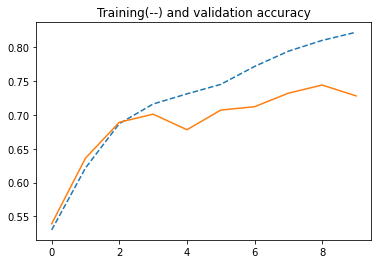

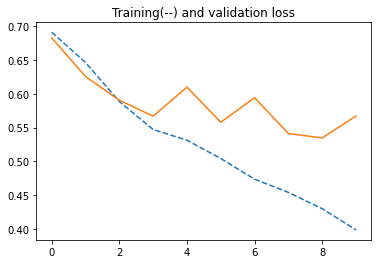

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '--')
plt.plot(epochs, val_acc)
plt.title('Training(--) and validation accuracy')

plt.figure()
plt.plot(epochs, loss,  '--')
plt.plot(epochs, val_loss)
plt.title('Training(--) and validation loss')


### 과대적합이 발생한 것을 알 수 있다.
- 모델은 복잡한데 적은 수의 데이터를 반복 (이포크) 사용하여 훈련시킨 때문으로 보임.



# data augmentation과 드롭아웃 사용

In [ ]:
train_datagen = ImageDataGenerator(
  rescale= 1./255,
  rotation_range = 40,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
											   target_size=(img_width,img_height),
# 											   classes=['dogs','cats'],
											   class_mode='binary',
											   batch_size=20)

validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
											   target_size=(img_width,img_height),
# 											   classes=['dogs','cats'],
											   class_mode='binary',
											   batch_size=20)


model = models.Sequential()

model.add(layers.Conv2D(32,(3,3), activation = 'relu', 
                        input_shape=(img_width, img_height, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### augmented 된 훈련 이미지는 마지막 셀에서 보세요...^^

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
    generator=train_generator, 
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 19s 191ms/step - loss: 0.6955 - acc: 0.5085 - val_loss: 0.6870 - val_acc: 0.5000
Epoch 2/30
100/100 [==============================] - 19s 188ms/step - loss: 0.6896 - acc: 0.5370 - val_loss: 0.6816 - val_acc: 0.5030
Epoch 3/30
100/100 [==============================] - 19s 189ms/step - loss: 0.6776 - acc: 0.5580 - val_loss: 0.6459 - val_acc: 0.6170
Epoch 4/30
100/100 [==============================] - 19s 189ms/step - loss: 0.6626 - acc: 0.6090 - val_loss: 0.6427 - val_acc: 0.6010
Epoch 5/30
100/100 [==============================] - 19s 188ms/step - loss: 0.6447 - acc: 0.6165 - val_loss: 0.5983 - val_acc: 0.6820
Epoch 6/30
100/100 [==============================] - 19s 189ms/step - loss: 0.6283 - acc: 0.6520 - val_loss: 0.6524 - val_acc: 0.6140
Epoch 7/30
100/100 [==============================] - 19s 188ms/step - loss: 0.6197 - acc: 0.6490 - val_loss: 0.6429 - val_acc: 0.6090
Epoch 8/30
100/100 [==============================] - 1

Text(0.5, 1.0, 'Training(--) and validation loss')

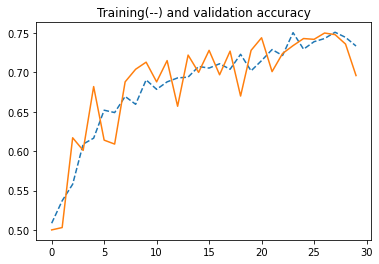

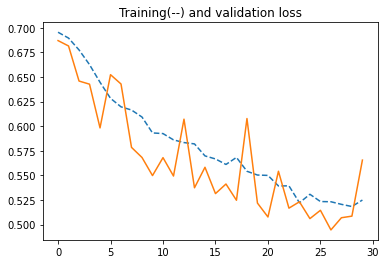

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '--')
plt.plot(epochs, val_acc)
plt.title('Training(--) and validation accuracy')

plt.figure()
plt.plot(epochs, loss,  '--')
plt.plot(epochs, val_loss)
plt.title('Training(--) and validation loss')

- 데이터 증식과 드롭아웃 덕택에 더이상 과대적합되지 않음을 볼 수 있다.

# Random 하게 데이터 증식한 훈련 이미지 그리기 (from the Keras book)


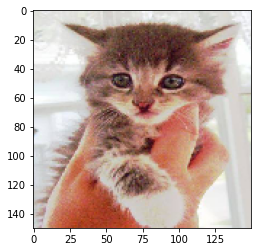

In [ ]:
from keras.preprocessing import image   # 이미지 전처리 유틸리티 모듈

fnames = sorted([os.path.join(train_cats_dir, fname) for 
                fname in os.listdir(train_cats_dir)])
img_path = fnames[3]  # 증식할 이미지 선택
img = image.load_img(img_path, target_size=(150,150)) # 이미지를 읽고 크기 변경

plt.imshow(img)

In [ ]:
train_datagen = ImageDataGenerator(
  rescale= 1./255,
  rotation_range = 40,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip = True)

In [ ]:
# ImageDataGen.flow(): Takes data & label arrays, generates batches of augmented data.
# 배치 데이터를 기대하기 떄문에 샘플 데이터에 배치 차원을 추가하여 4-d 텐서로 만듬.

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)    # (1,150,150,3) 크기로 변환
print(x.shape)

(1, 150, 150, 3)


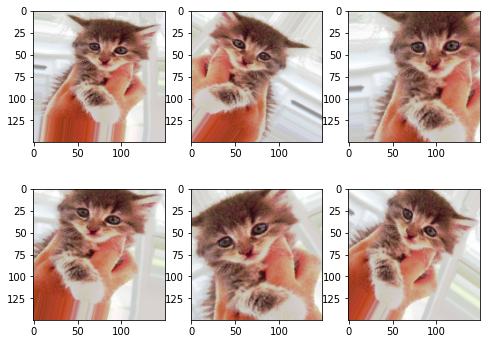

In [ ]:
i = 0
plt.figure(figsize=(8,6))
for batch in train_datagen.flow(x, batch_size=1):   # endless loop (need break)
    plt.subplot(2,3,i+1)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i +=1
    if i % 6 == 0:
        break
plt.show()

# For your reference

In [ ]:
a = np.array([[1,2],[3,4]])
print(a.shape)
print(a.reshape(4,1))
print((1,) + a.shape)
(1,4) + (2,3)   # tuple concatenation

(2, 2)
[[1]
 [2]
 [3]
 [4]]
(1, 2, 2)


(1, 4, 2, 3)